# Running simulations with PySONIC

This notebook illustrates how to simulate a point-neuron model upon application of both electrical and ultrasonic stimuli, with various temporal protocols.

## Import PySONIC modules

In [1]:
import logging
import matplotlib.pyplot as plt
from PySONIC.utils import logger
from PySONIC.neurons import getPointNeuron, getNeuronsDict
from PySONIC.core import NeuronalBilayerSonophore, DrivenNeuronalBilayerSonophore, ElectricDrive, AcousticDrive
from PySONIC.core.protocols import *
from PySONIC.plt import GroupedTimeSeries, CompTimeSeries

# Set logging level
logger.setLevel(logging.INFO)

## Instantiate a point-neuron model

We start by instantiating a point-neuron model of a particular neuron type. To list the available point-neuron models, type in:

In [2]:
for k, v in getNeuronsDict().items():
    print(f'- {k}: {v}')

- FS: <class 'PySONIC.neurons.cortical.CorticalFS'>
- IB: <class 'PySONIC.neurons.cortical.CorticalIB'>
- LTS: <class 'PySONIC.neurons.cortical.CorticalLTS'>
- RS: <class 'PySONIC.neurons.cortical.CorticalRS'>
- FHnode: <class 'PySONIC.neurons.fh.FrankenhaeuserHuxleyNode'>
- HHseg: <class 'PySONIC.neurons.hh.HodgkinHuxleySegment'>
- LeechP: <class 'PySONIC.neurons.leech.LeechPressure'>
- LeechR: <class 'PySONIC.neurons.leech.LeechRetzius'>
- LeechT: <class 'PySONIC.neurons.leech.LeechTouch'>
- MRGnode: <class 'PySONIC.neurons.mrg.MRGNode'>
- STN: <class 'PySONIC.neurons.stn.OtsukaSTN'>
- SUseg: <class 'PySONIC.neurons.sundt.SundtSegment'>
- SWnode: <class 'PySONIC.neurons.sweeney.SweeneyNode'>
- template: <class 'PySONIC.neurons.template.TemplateNeuron'>
- RE: <class 'PySONIC.neurons.thalamic.ThalamicRE'>
- TC: <class 'PySONIC.neurons.thalamic.ThalamoCortical'>


We will choose here a cortical regular spiking (RS) neuron, by providing its key to the `getPointNeuron` method:

In [3]:
pneuron = getPointNeuron('RS')

## Define a stimulus

In PySONIC, a stimulus is defined by the combination of 2 objects:

#### 1. Stimulus drive

The "drive" object specifies the fundamental properties of the stimulus (e.g. nominal amplitude, carrier frequency). 

Let's start by simulating our point-neuron model upon electrical stimulation (using a standard Hodgkin-Huxley paradigm). To do so, we define an `ElectricDrive` object that specifies a current density (in mA/m2) injected intracellularly into our point neuron model. 

In [4]:
i = 20.  # mA/m2
ELdrive = ElectricDrive(i)

#### 2. Time protocol

The "time protocol" object specifying how the stimulus drive amplitude is modulated over time (e.g. continuous stimulation, pulsed stimulation, ...).

We define here a standard `PulsedProtocol` consisting of a unique pulse of 100 ms, starting with a delay of 10 ms, and followed by a 100 ms offset where the stimulus is turned off:

In [5]:
tstart = 0e-3    # s
tpulse = 100e-3   # s
toffset = 100e-3  # s
pp = PulsedProtocol(tpulse, toffset, tstart=tstart)

## Run a simulation

Let's simulate our point-neuron model upon application of this pulsed electrical stimulus, by calling the model's `simulate` method:

In [6]:
data, meta = pneuron.simulate(ELdrive, pp)

 02/03/2021 14:59:08: CorticalRS: simulation @ I = 20.0mA/m2, tstim = 100ms, toffset = 100ms


As you can see, this method returns a `(data, meta)` tuple.

The `data` field is a dataframe containing the resulting time series of all the differential variables of the model:

In [7]:
data.head()

,t,stimstate,Qm,Vm,m,h,n,p
0,0.00000,0.0,-0.000719,-71.900000,0.000451,0.999926,0.002227,0.024364
1,0.00000,0.0,-0.000719,-71.900000,0.000451,0.999926,0.002227,0.024364
2,0.00000,0.0,-0.000719,-71.900000,0.000451,0.999926,0.002227,0.024364
3,0.00000,1.0,-0.000719,-71.900000,0.000451,0.999926,0.002227,0.024364
4,0.00005,1.0,-0.000718,-71.800019,0.000454,0.999926,0.002228,0.024364


The `meta` dictionary stores information about the simulation (model type, stimulus, pulsed protocol) that can be used to recreate an identical simulation if needed.

In [8]:
for k, v in meta.items():
    print(f'- {k}: {v}')

- simkey: ESTIM
- model: {'neuron': 'RS'}
- drive: ElectricDrive(I=20.0mA/m2)
- pp: PulsedProtocol(tstim=100ms, toffset=100ms)
- tcomp: 0.18283270000000051


## Visualize results

#### Plot all time series of a simulation

Simulation results can be easily visualized by feeding the simulation output (the `(data, meta)` tuple) into a `GroupedTimeSeries` object. Note that this object can accept outputs from multiple simulations, hence the output must be wrapped in a list:

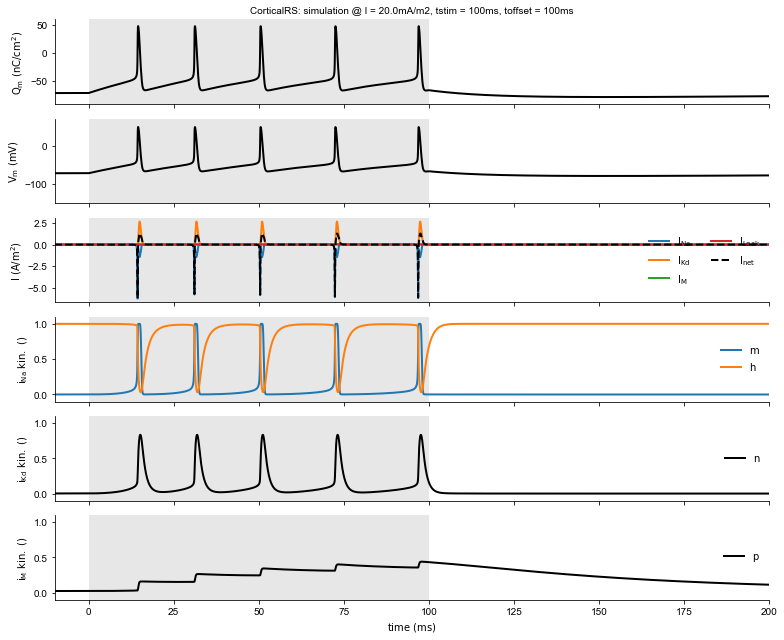

In [9]:
fig = GroupedTimeSeries([(data, meta)]).render()

We can see here the evolution of the neuron's membrane charge density, membrane potential and membrane currents, as well as that of the gating states of its constituent ion channels. The gray stripe indicates when the stimulus is turned on by the pulsed protocol.

#### Compare time series from different simulations

Alternatively, you can compare results of 2 or more simulations different only by a single parameter within a single graph, using a `CompTimeSeries` object:

 02/03/2021 14:59:09: CorticalRS: simulation @ I = 30.0mA/m2, tstim = 100ms, toffset = 100ms


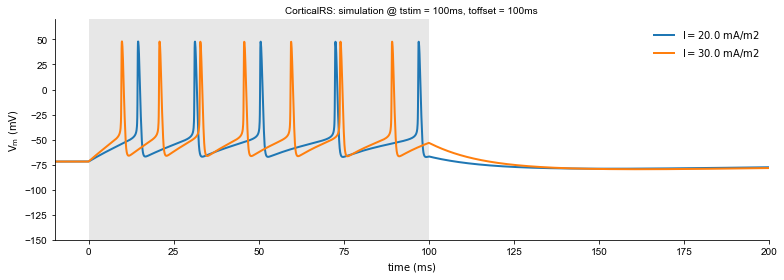

In [10]:
out = pneuron.simulate(ElectricDrive(30.), pp)  # Run simulation with different current amplitude
outputs = [(data, meta), out]  # wrap the two simulation outputs into a list
fig = CompTimeSeries(outputs, 'Vm').render()  # compare membrane potential profiles

## Trying different protocols

#### A more complex pulsed protocol

First, let's try a more complex `PulsedProtocol` consisting of multiple pulses repeated at a given frequency and with a given duty cycle:

 02/03/2021 14:59:10: CorticalRS: simulation @ I = 20.0mA/m2, tstim = 100ms, toffset = 100ms, PRF = 100.00Hz, DC = 50.0%


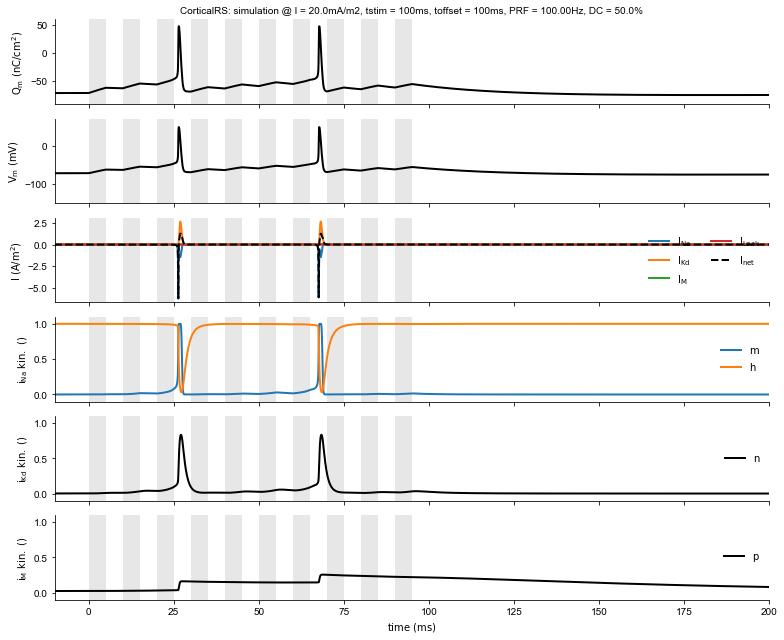

In [11]:
tburst = 100e-3  # ms
PRF = 100.       # Hz
DC = 0.5         # -
pp2 = PulsedProtocol(tburst, toffset, PRF=PRF, DC=DC, tstart=tstart)
data, meta = pneuron.simulate(ELdrive, pp2)
fig = GroupedTimeSeries([(data, meta)]).render()

#### Burst protocol

Second, let's try a `BurstProtocol` that combines 2 "pulsing layers" by repeating bursts of pulses at a given frequency:

 02/03/2021 14:59:11: CorticalRS: simulation @ I = 20.0mA/m2, tburst = 100ms, PRF = 100.00Hz, DC = 50.0%, BRF = 2.0Hz, nbursts = 3


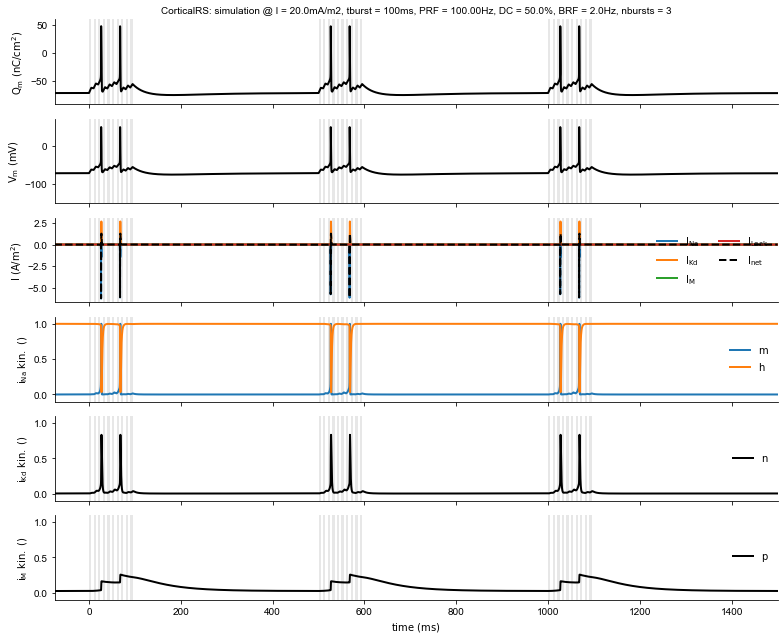

In [12]:
BRF = 2.0    # Hz
nbursts = 3  # -
bp = BurstProtocol(tburst, PRF=PRF, DC=DC, BRF=BRF, nbursts=nbursts, tstart=tstart)
data, meta = pneuron.simulate(ELdrive, bp)
fig = GroupedTimeSeries([(data, meta)]).render()

#### Custom protocol

Finally, let's try a `CustomProtocol` defined by a list of time instants and modulation amplitudes describing how the drive is modulated over time:

 02/03/2021 14:59:13: CorticalRS: simulation @ I = 20.0mA/m2, tevents = (10.00m, 30.00m, 50.00m)s, xevents = (1.0, 2.0, 0.0), tstop = 100ms


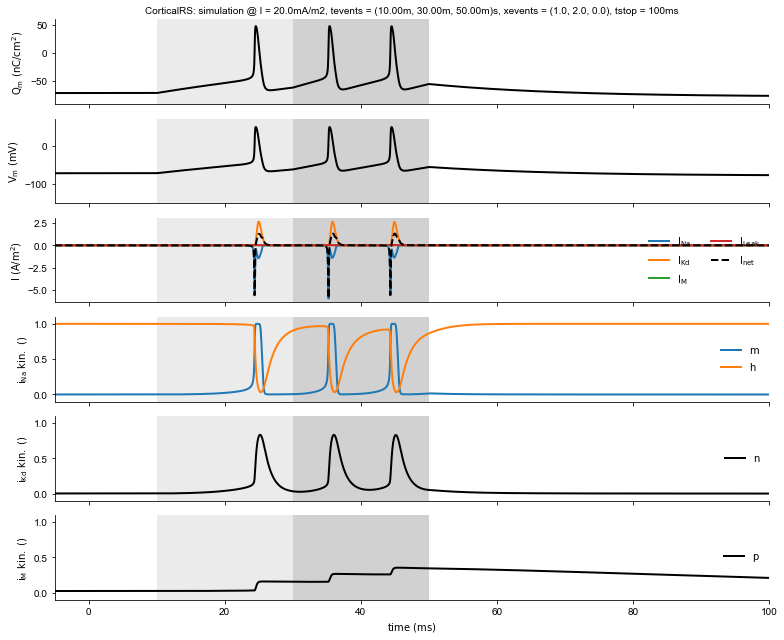

In [13]:
mod_times = [10e-3, 30e-3, 50e-3]
mod_amps = [1., 2., 0.]
cp = CustomProtocol(mod_times, mod_amps, toffset)
data, meta = pneuron.simulate(ELdrive, cp)
fig = GroupedTimeSeries([(data, meta)]).render()

The different shades of gray indicate here the relative modulation amplitudes of the stimulus over time.

# Ultrasonic stimulation

Let's now move on to the main purpose of the PySONIC framework: to simulate neural dynamics upon ultrasonic stimulation. For this purpose, PySONIC uses the **SONIC model**, a computationally efficient paradigm of the *Neuronal Intramembrane Cavitation Excitation (NICE)* model that represents the mechano-electrical dynamics of a nanoscale membrane structure resonating to ultrasound, so-called *bilayer sonophore*. 

#### Neuronal Bilayer Sonophore

To simulate the behavior of a point-neuron model upon ultrasonic stimulation, one must first define a `NeuronalBilayerSonophore` object. This is done by specifying a sonophore radius and an associated point-neuron object:

In [14]:
a = 32e-9  # sonophore radius (m)
nbls = NeuronalBilayerSonophore(a, pneuron)

#### Acoustic drive

Then, one must define an `AcousticDrive` object specifying the carrier frequency (in Hz) and peak pressure amplitude (in Pa) of the ultrasound stimulus:

In [15]:
Fdrive = 500e3  # Hz
Adrive = 100e3  # Pa
USdrive = AcousticDrive(Fdrive, Adrive)

### Simulations

Similarly as for electrical stimulation, acoustic stimulation can be simulated by calling the `simulate` method of the instantiated `NeuronalBilayerSonophore` object, with the appropriate acoustic drive and time protocol.

#### Single-pulse protocol

 02/03/2021 14:59:14: NeuronalBilayerSonophore(32.0 nm, CorticalRS): sonic simulation @ f = 500kHz, A = 100.00kPa, tstim = 100ms, toffset = 100ms


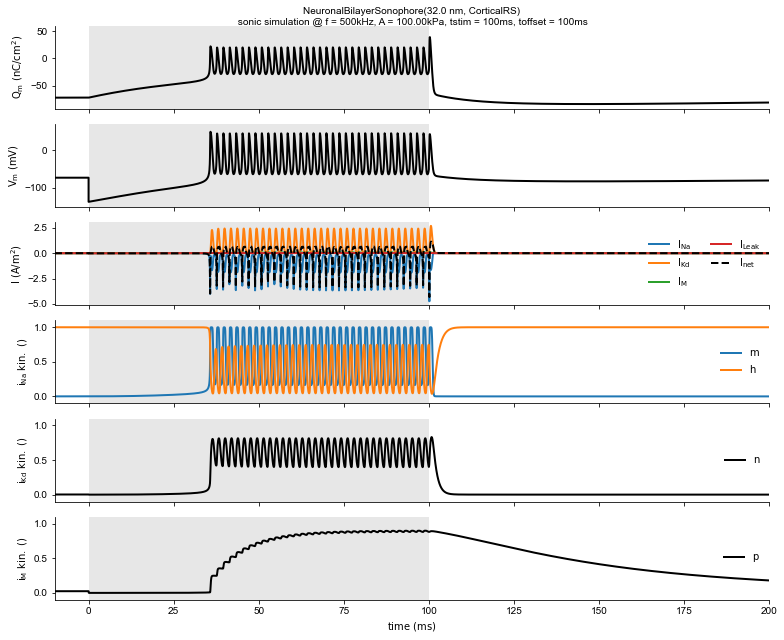

In [16]:
data, meta = nbls.simulate(USdrive, pp)
fig = GroupedTimeSeries([(data, meta)]).render()

#### Pulsed protocol

 02/03/2021 14:59:20: NeuronalBilayerSonophore(32.0 nm, CorticalRS): sonic simulation @ f = 500kHz, A = 100.00kPa, tstim = 100ms, toffset = 100ms, PRF = 100.00Hz, DC = 50.0%


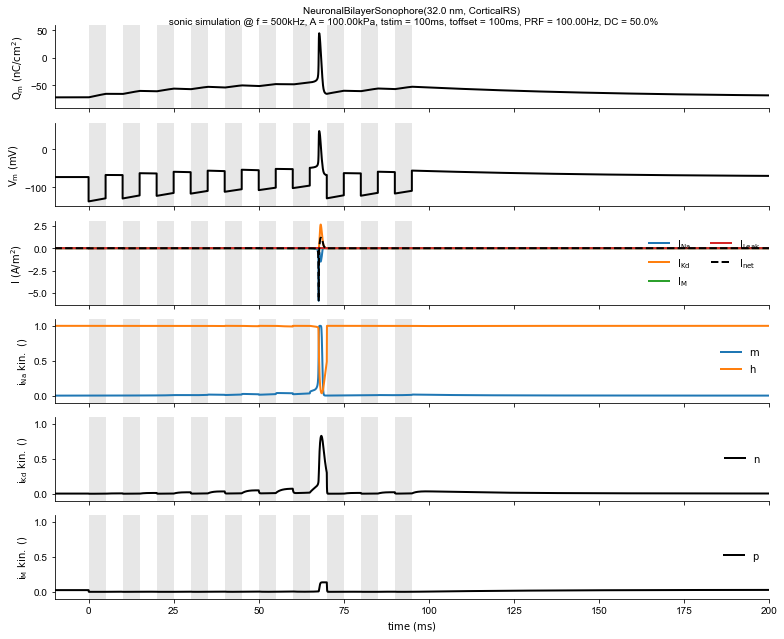

In [17]:
data, meta = nbls.simulate(USdrive, pp2)
fig = GroupedTimeSeries([(data, meta)]).render()

#### Burst protocol

 02/03/2021 14:59:21: NeuronalBilayerSonophore(32.0 nm, CorticalRS): sonic simulation @ f = 500kHz, A = 100.00kPa, tburst = 100ms, PRF = 100.00Hz, DC = 50.0%, BRF = 2.0Hz, nbursts = 3


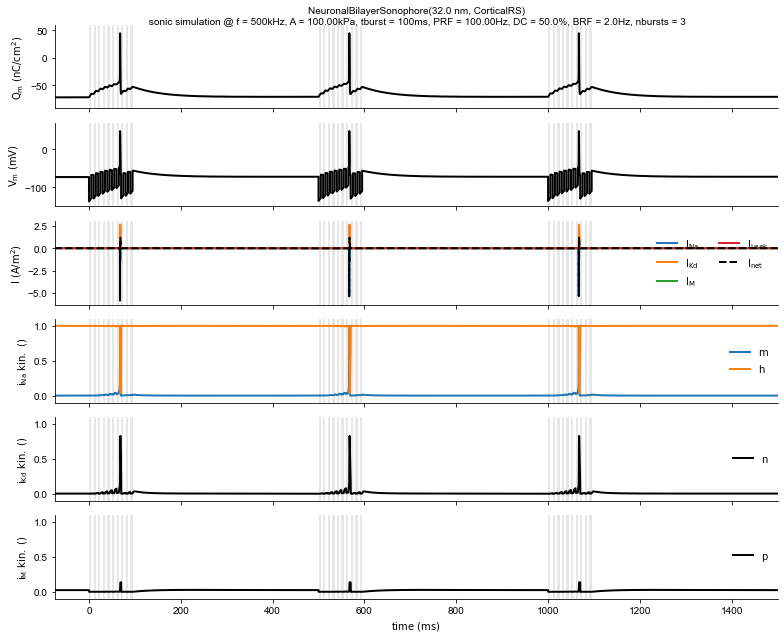

In [18]:
data, meta = nbls.simulate(USdrive, bp)
fig = GroupedTimeSeries([(data, meta)]).render()

#### Custom protocol

 02/03/2021 14:59:25: NeuronalBilayerSonophore(32.0 nm, CorticalRS): sonic simulation @ f = 500kHz, A = 100.00kPa, tevents = (10.00m, 30.00m, 50.00m)s, xevents = (1.0, 2.0, 0.0), tstop = 100ms


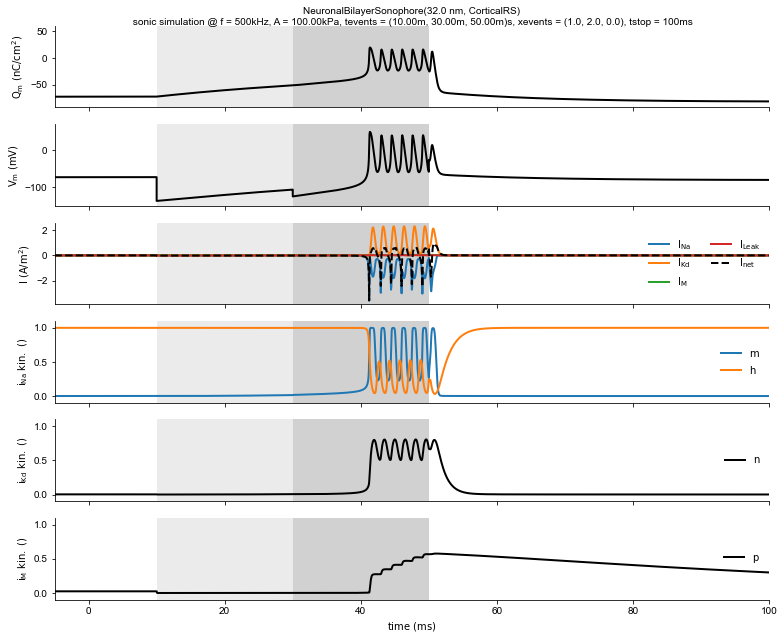

In [19]:
data, meta = nbls.simulate(USdrive, cp)
fig = GroupedTimeSeries([(data, meta)]).render()

## Combining electrical and ultrasonic stimulation

The PySONIC framework also allows to simulate neural dynamics upon combined electrical and ultrasonic stimulation.

This feature is still in development. At the moment, the electrical stimulus can only be defined as a constant injected current, while the acoustic stimulus is a full-fledged stimulus. 

To perform this combined simulation, you must define a `DrivenNeuronalBilayerSonophore` object by specifying a driving current amplitude, a sonophore radius and a point-neuron model. The simulation call is unchanged.  

For instance, we compare compare here the behavior of the regular spiking neuron upon ultrasonic stimulation, while driven by different electrical current densities:

 02/03/2021 14:59:27: DrivenNeuronalBilayerSonophore(32.0 nm, CorticalRS, Idrive = -5.00 mA/m2): sonic simulation @ f = 500kHz, A = 100.00kPa, tstim = 100ms, toffset = 100ms
 02/03/2021 14:59:29: DrivenNeuronalBilayerSonophore(32.0 nm, CorticalRS, Idrive = 0.00 mA/m2): sonic simulation @ f = 500kHz, A = 100.00kPa, tstim = 100ms, toffset = 100ms
 02/03/2021 14:59:34: DrivenNeuronalBilayerSonophore(32.0 nm, CorticalRS, Idrive = 5.00 mA/m2): sonic simulation @ f = 500kHz, A = 100.00kPa, tstim = 100ms, toffset = 100ms


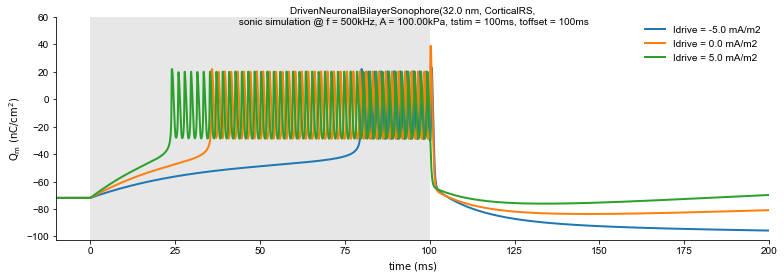

In [20]:
Idrives = [-5.0, 0., 5.0]  # mA/m2
outputs = []
for Idrive in Idrives:
    dnbls = DrivenNeuronalBilayerSonophore(Idrive, a, pneuron)
    outputs.append(dnbls.simulate(USdrive, pp))
fig = CompTimeSeries(outputs, 'Qm').render(labels=[f'Idrive = {x:.1f} mA/m2' for x in Idrives])